In [1]:
import pandas as pd
import seaborn as sns
import numpy as np


We use this dataset in a regression setting to predict the sale prices of houses based on house features. That is, the goal is to predict the target `SalePrice` from numeric and/or categorical features in the dataset.

Remember to explore the dataset before building models. Then, start simple and step-by-step expand your approach to create better and better models.


In [2]:
ames_data = pd.read_csv("../datasets/ames_housing_no_missing.csv")

In [3]:
ames_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,Gd,MnPrv,Shed,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Grvl,Reg,Lvl,AllPub,FR2,...,0,Gd,MnPrv,Shed,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,0,Gd,MnPrv,Shed,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,0,Gd,MnPrv,Shed,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,Grvl,IR1,Lvl,AllPub,FR2,...,0,Gd,MnPrv,Shed,0,12,2008,WD,Normal,250000


## Data exploration

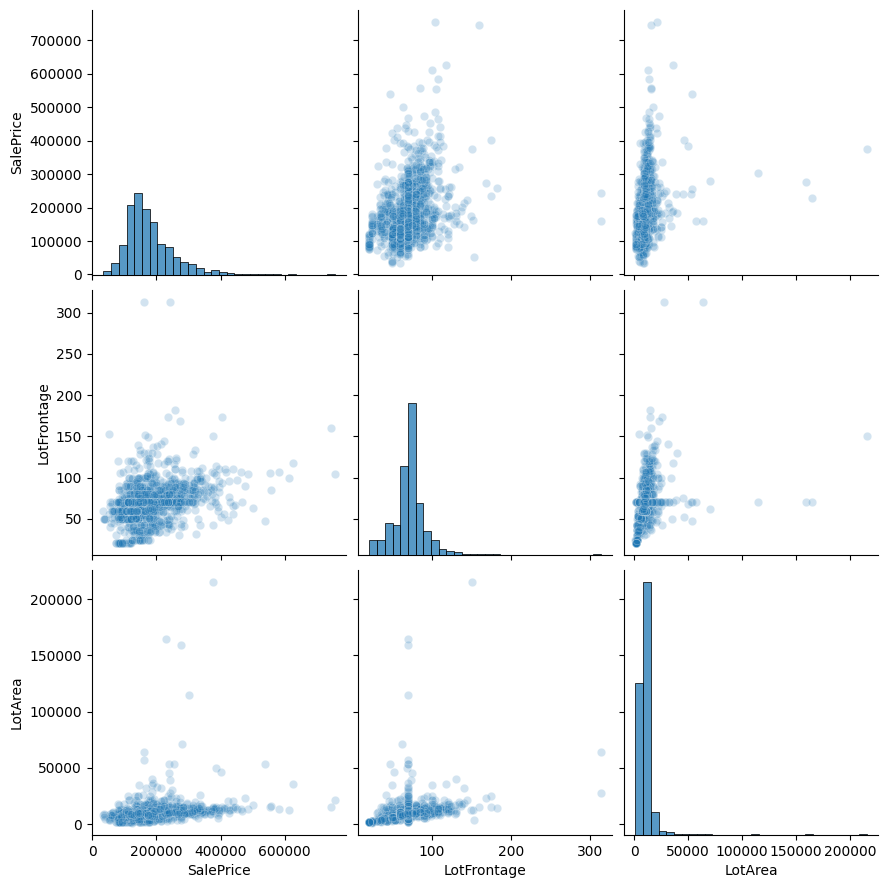

In [4]:

# We plot a subset of the data to keep the plot readable and make the plotting
# faster
n_samples_to_plot = 5000
columns = ["SalePrice", "LotFrontage", "LotArea"]
_ = sns.pairplot(
    data=ames_data[:n_samples_to_plot],
    vars=columns,
    hue=None,
    plot_kws={"alpha": 0.2},
    height=3,
    diag_kind="hist",
    diag_kws={"bins": 30},
)

In [5]:
target_col = "SalePrice"
target = ames_data[target_col]
data = ames_data.drop(columns=[target_col])

## Data preprocessing

In [6]:
data.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [7]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)
data[categorical_columns].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
1,RL,Pave,Grvl,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
2,RL,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
3,RL,Pave,Grvl,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Abnorml
4,RL,Pave,Grvl,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal


In [8]:
data["MiscFeature"].unique()

array(['Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

**What to do with categorical data?**
- ordinal encoding? -> variables are not necessarily ordinal
- one-hot encoding? -> trees not well suited for it

What can we do?
- encode the categorical variables in a reduced space? but this does not get rid of the problem
- what is a scalable way? we can select `top k`, check their encoding

In [9]:
integer_columns_selector = selector(dtype_include=np.int64)
integer_columns = integer_columns_selector(data)
data[integer_columns].head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,8450,7,5,2003,2003,706,0,150,856,...,548,0,61,0,0,0,0,0,2,2008
1,20,9600,6,8,1976,1976,978,0,284,1262,...,460,298,0,0,0,0,0,0,5,2007
2,60,11250,7,5,2001,2002,486,0,434,920,...,608,0,42,0,0,0,0,0,9,2008
3,70,9550,7,5,1915,1970,216,0,540,756,...,642,0,35,272,0,0,0,0,2,2006
4,60,14260,8,5,2000,2000,655,0,490,1145,...,836,192,84,0,0,0,0,0,12,2008


In [10]:
float_columns_selector = selector(dtype_include=np.float64)
float_columns = float_columns_selector(data)
data[float_columns].head()

,LotFrontage,MasVnrArea,GarageYrBlt
0,65.0,196.0,2003.0
1,80.0,0.0,1976.0
2,68.0,162.0,2001.0
3,60.0,0.0,1998.0
4,84.0,350.0,2000.0


## Fit model

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_validate


In [12]:
clf = RandomForestClassifier(max_depth=4, random_state=0)

In [18]:
columns_to_use = integer_columns + float_columns
columns_to_use

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'LotFrontage',
 'MasVnrArea',
 'GarageYrBlt']

In [19]:
clf.fit(data[integer_columns], target)

,n_estimators,100
,criterion,'gini'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
cv_result = cross_validate(clf, data[integer_columns], target, cv=5)

/home/flavio/repositories/teaching/sicss-2025/ml_workshop/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/flavio/repositories/teaching/sicss-2025/ml_workshop/lib/python3.12/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/home/flavio/repositories/teaching/sicss-2025/ml_workshop/lib/python3.12/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/home/flavio/repositories/teaching/sicss-2025/ml_workshop/lib/python3.12/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ty

In [21]:
cv_result

{'fit_time': array([0.29027843, 0.2835288 , 0.28599572, 0.28823805, 0.28980684]),
 'score_time': array([0.01410151, 0.01447558, 0.01398516, 0.0143013 , 0.01411366]),
 'test_score': array([0.01712329, 0.01369863, 0.01712329, 0.02054795, 0.02054795])}